# ステップ４　混合ガウスモデル
- 混合カオスモデル：複数の正規分布を組み合わせることで，より複雑な表現をすることができる（一つの正規分布では表せない現象が存在する）
## 4.1 身の回りにある多峰性分布
- 多峰性分布：複数の山を持つ分布
- 多峰性分布の例
   - 男女混合の同年齢の身長の分布：男女異なる正規分布が二つあるような分布
   - アリの体長の分布：一つの群れでも複数の分布で構成される
   - 間欠泉：今回扱う分布

![heights_17](./output/height_distribution_17yo.png)
### 4.1.1 多峰性分布のデータセット

In [1]:
import numpy as np
import matplotlib.pyplot as plt

path = 'data/old_faithful.txt'
xs = np.loadtxt(path)

print(xs.shape)
print(xs[0]) # 噴出した時間:3.6分，次の噴出までの時間:79分
print(xs[1]) # 噴出した時間:1.8分，次の噴出までの時間:54分

(272, 2)
[ 3.6 79. ]
[ 1.8 54. ]


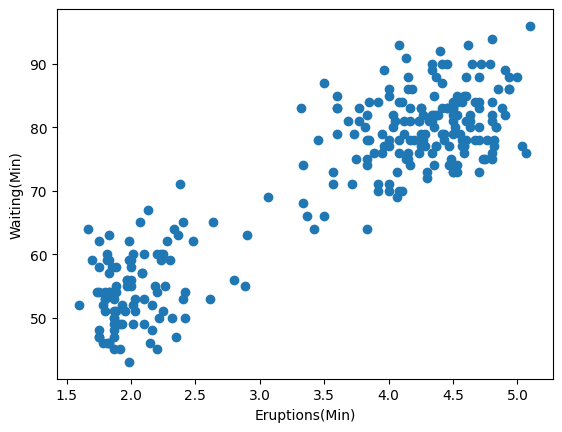

In [2]:
plt.scatter(xs[:,0], xs[:,1])
plt.xlabel('Eruptions(Min)')
plt.ylabel('Waiting(Min)')
plt.show()

## 4.2 混合ガウスモデルのデータ生成
- 混合ガウスモデル（GMM）：複数の正規分布からなるモデル
- GMMによる生成モデルについて
    - モデル化：観測データの分布がGMMによって表現できると仮定
    - パラメータ推定：GMMのパラメータを推定
        - GMMではパラメータ推定が困難であり，最尤推定で解析的に求めることができない
        - 解決策であるEMアルゴリズムについては次週扱う
### 4.2.1 GMMによるデータ生成
##### 分布が二つの場合
- ある確率分布に従って，2つの正規分布の中かから1つ選ぶ
- 選んだ正規分布からデータを生成する
### 4.2.2 データ生成を行うコード

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 2種類の分布のパラメータを配列に格納
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00 ]]])
phis = np.array([0.35, 0.65]) # 1つ目の分布が選ばれる確率：0.35, 2つ目の分布が選ばれる確率：0.65

def sample():
    k = np.random.choice(2, p=phis) # 2つの分布から1つをphisの確率に従って選ぶ
    mu, cov = mus[k], covs[k] # 選ばれた分布のパラメータを取得
    x = np.random.multivariate_normal(mu, cov) # 選ばれた分布からサンプリング
    return x


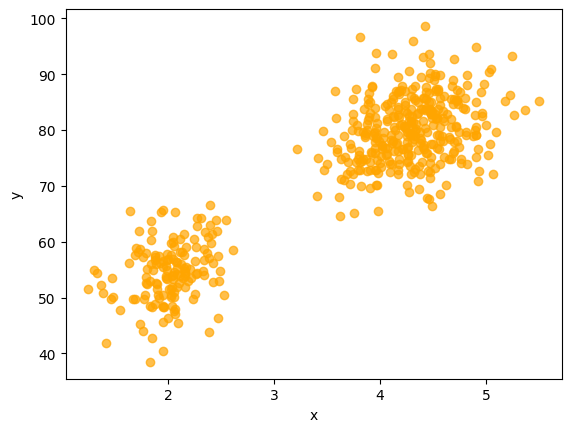

In [7]:
N = 500
xs = np.zeros((N, 2))
for i in range(N):
     xs[i] = sample()

plt.scatter(xs[:,0], xs[:,1], color='orange', alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 4.3 混合ガウスモデルの式
### 4.3.1　確率の復習
- 同時確率：$p(x,y)$
- 周辺確率：$p(x)$や$p(y)$などの，確率変数単独の確率
- 周辺化：同時確率から，特定の確率変数を取り除き，周辺確率を求めること（式は以下の通り）
$$
\begin{align}
p(x) &= \sum_y p(x, y) \text{　(離散変数の場合)}\\
p(x) &= \int p(x,y)dy \text{　(連続変数の場合)}
\end{align}
$$
- 条件付き確率：$p(x|y)=\text{yが起きている条件でのxが起こる確率}$
- 乗法定理：$p(x,y) = p(x|y)p(y)$
### 4.3.2 GMMの式
##### 分布がK種類の場合
- K種類の正規分布から，ある確率分布（カテゴリカル分布）に従って1つ選ぶ
- 選んだ正規分布からデータ生成
- カテゴリカル分布：$p(z = k; \phi) = \phi_k$
    - z：離散型の確率変数（１〜K）
    - $\phi$：カテゴリカル分布のパラメータ（２クラスカテゴリカル分布＝(0.35, 0.65)）
    - $\phi$の条件
        - $\forall k 　\phi_k>0$
        - $\sum_1^K\phi_k = 1$
##### GMMの式導出
- z=kのときのxの確率分布は，k番目の正規分布を示す
$$p(x \mid z = k; \mu, \Sigma) = \mathcal{N}(x; \mu_k, \Sigma_k)$$
- 生成モデルの目標である確率$p(x)$を求めるために，周辺化する
$$p(x) = \sum_{k=1}^{K} p(x, z = k)$$
- 乗法定理より以下が成り立つ
$$
\begin{align}
p(x, z = k) &= p(z = k) \, p(x \mid z = k)\\
&= \phi_k \, \mathcal{N}(x; \mu_k, \Sigma_k)
\end{align}
$$
- 故に以下のGMMのモデル式が成立
$$p(x) = \sum_{k=1}^{K} \phi_k \, \mathcal{N}(x; \mu_k, \Sigma_k)$$
- x:学習用の観測データ
- z: 潜在変数（観測されない変数）
### 4.3.3 GMMの実装

In [9]:
mus = np.array([[2.0, 54.50],
                [4.3, 80.0]])
covs = np.array([[[0.07, 0.44],
                  [0.44, 33.7]],
                 [[0.17, 0.94],
                  [0.94, 36.00 ]]])
phis = np.array([0.35, 0.65])

def multivariate_normal(x, mu, cov):
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    d = len(x)
    z = 1 / np.sqrt((2 * np.pi) ** d * det)
    y = z * np.exp((x - mu).T @ inv @ (x - mu) / -2.0)
    return y

def gmm(x, phis, mus, covs):
    K = len(phis)
    y = 0
    for k in range(K):
        phi, mu, cov = phis[k], mus[k], covs[k]
        y += phi * multivariate_normal(x, mu, cov) # 各正規分布の確率密度関数の重みつき和
    return y

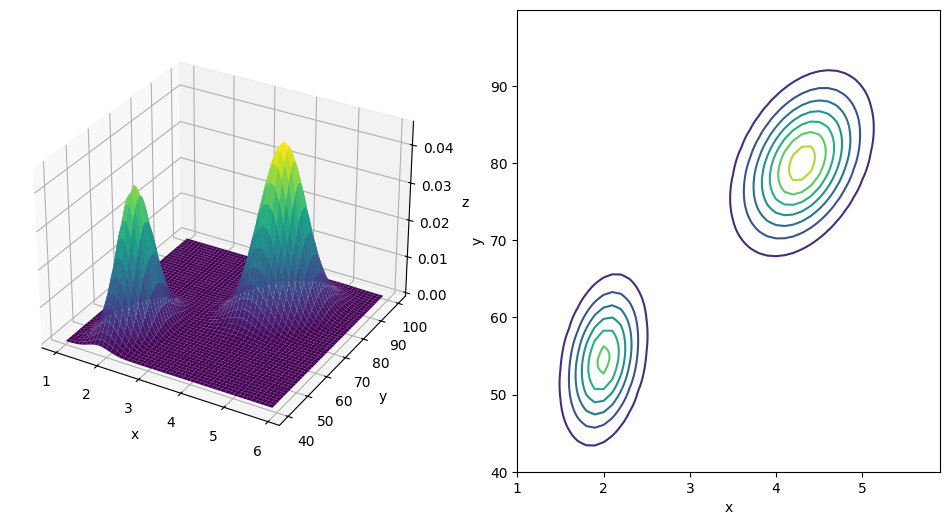

In [10]:
xs = np.arange(1, 6, 0.1)
ys = np.arange(40, 100, 0.1)
X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = np.array([X[i, j], Y[i, j]])
        Z[i, j] = gmm(x, phis, mus, covs)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot_surface(X, Y, Z, cmap='viridis')

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.contour(X, Y, Z)
plt.show()

## 4.4 パラメータ推定の難所
$$
\begin{align}
\log p(\mathcal{D}; \theta) 
&= \log \prod_{n=1}^{N} p(x^{(n)}; \theta)\\
&= \sum_{n=1}^{N} \log p(x^{(n)}; \theta)\\
&= \sum_{n=1}^{N} \log \left( \sum_{k=1}^{K} \phi_k \, \mathcal{N}(x^{(n)}; \mu_k, \Sigma_k) \right)
\end{align}
$$
上記の式から以下の微分の式を解析的に解く必要がある
$$
\frac{\partial L}{\partial \phi} = 0 \quad
\frac{\partial L}{\partial \mu} = 0 \quad
\frac{\partial L}{\partial \Sigma} = 0
$$
しかし，式を見たらわかるようにlog-sumの式があり，これは解析的に解くのが難しい（sum-logは容易，またK=1のときはlogとexpが打ち消し合うことで解析的に解くことができる）
